#**Song Genre Prediction**

In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install h5py pyyaml # To handle large Binary data as numpy array
# !pip install tf_nightly

Connect to drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


go to project directory (kaggle.json is downloaded, so that data from kaggle can be imported to that location in drive)

In [3]:
%cd /gdrive/My\ Drive/ML_AI/SongGenrePrediction/kaggle/
%ls -lrt

/gdrive/My Drive/ML_AI/SongGenrePrediction/kaggle
total 2384
-rw------- 1 root root      66 Nov  6 06:40  kaggle.json
drwx------ 2 root root    4096 Nov  6 07:25 'gtzan-dataset-music-genre-classification.zip (Unzipped Files)'/
drwx------ 2 root root    4096 Nov  6 07:58  genres/
-rw------- 1 root root 1323052 Nov  6 08:01 'Copy of pop.00001.wav'
-rw------- 1 root root 1108271 Nov  6 08:52  data.csv
-rw------- 1 root root     146 Nov  6 09:55  X_scaler.pickle
-rw------- 1 root root       0 Nov  6 10:28  trained_model_for_genre_prediction.pickle


Set the drive location as config location and download data from kaggle to that location and unzip it (only once)

In [ ]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/gdrive/My Drive/ML_AI/SongGenrePrediction/kaggle/"
# !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:33<00:00, 35.2MB/s]
100% 1.21G/1.21G [00:33<00:00, 38.9MB/s]


In [4]:
%cd /gdrive/My\ Drive/ML_AI/SongGenrePrediction/kaggle/
%ls -lrt


/gdrive/My Drive/ML_AI/SongGenrePrediction/kaggle
total 2384
-rw------- 1 root root      66 Nov  6 06:40  kaggle.json
drwx------ 2 root root    4096 Nov  6 07:25 'gtzan-dataset-music-genre-classification.zip (Unzipped Files)'/
drwx------ 2 root root    4096 Nov  6 07:58  genres/
-rw------- 1 root root 1323052 Nov  6 08:01 'Copy of pop.00001.wav'
-rw------- 1 root root 1108271 Nov  6 08:52  data.csv
-rw------- 1 root root     146 Nov  6 09:55  X_scaler.pickle
-rw------- 1 root root       0 Nov  6 10:28  trained_model_for_genre_prediction.pickle


In [ ]:
os.listdir('genres/blues')

['blues.00044.wav',
 'blues.00043.wav',
 'blues.00042.wav',
 'blues.00041.wav',
 'blues.00040.wav',
 'blues.00037.wav',
 'blues.00038.wav',
 'blues.00039.wav',
 'blues.00036.wav',
 'blues.00035.wav',
 'blues.00034.wav',
 'blues.00033.wav',
 'blues.00032.wav',
 'blues.00031.wav',
 'blues.00030.wav',
 'blues.00029.wav',
 'blues.00028.wav',
 'blues.00027.wav',
 'blues.00026.wav',
 'blues.00025.wav',
 'blues.00024.wav',
 'blues.00023.wav',
 'blues.00022.wav',
 'blues.00021.wav',
 'blues.00020.wav',
 'blues.00019.wav',
 'blues.00018.wav',
 'blues.00017.wav',
 'blues.00016.wav',
 'blues.00015.wav',
 'blues.00014.wav',
 'blues.00013.wav',
 'blues.00012.wav',
 'blues.00011.wav',
 'blues.00010.wav',
 'blues.00009.wav',
 'blues.00008.wav',
 'blues.00007.wav',
 'blues.00005.wav',
 'blues.00006.wav',
 'blues.00004.wav',
 'blues.00003.wav',
 'blues.00002.wav',
 'blues.00001.wav',
 'blues.00000.wav',
 'blues.00045.wav',
 'blues.00091.wav',
 'blues.00090.wav',
 'blues.00089.wav',
 'blues.00088.wav',


Load the input song

In [ ]:
import time
songname=f'Copy of pop.00001.wav'

Sampling of audio signal

Sampled values Count: 110250,
Sampled values eg:[-0.40075684 -0.4593506  -0.56152344 -0.44036865 -0.49102783]


Text(0.5, 1.0, 'Sampled signal plot')

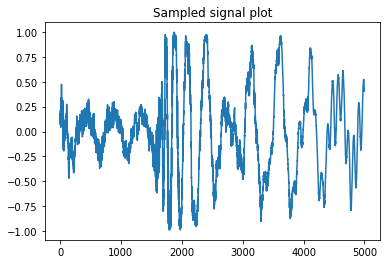

In [ ]:
y, sr = librosa.load(songname, mono=True, duration=5)
print(f'Sampled values Count: {len(y)},\nSampled values eg:{y[1000:1005]}')
plt.plot(range(0,len(y[10000:15000])),y[10000:15000])
plt.title('Sampled signal plot')

Spectogram platting for sampled signal

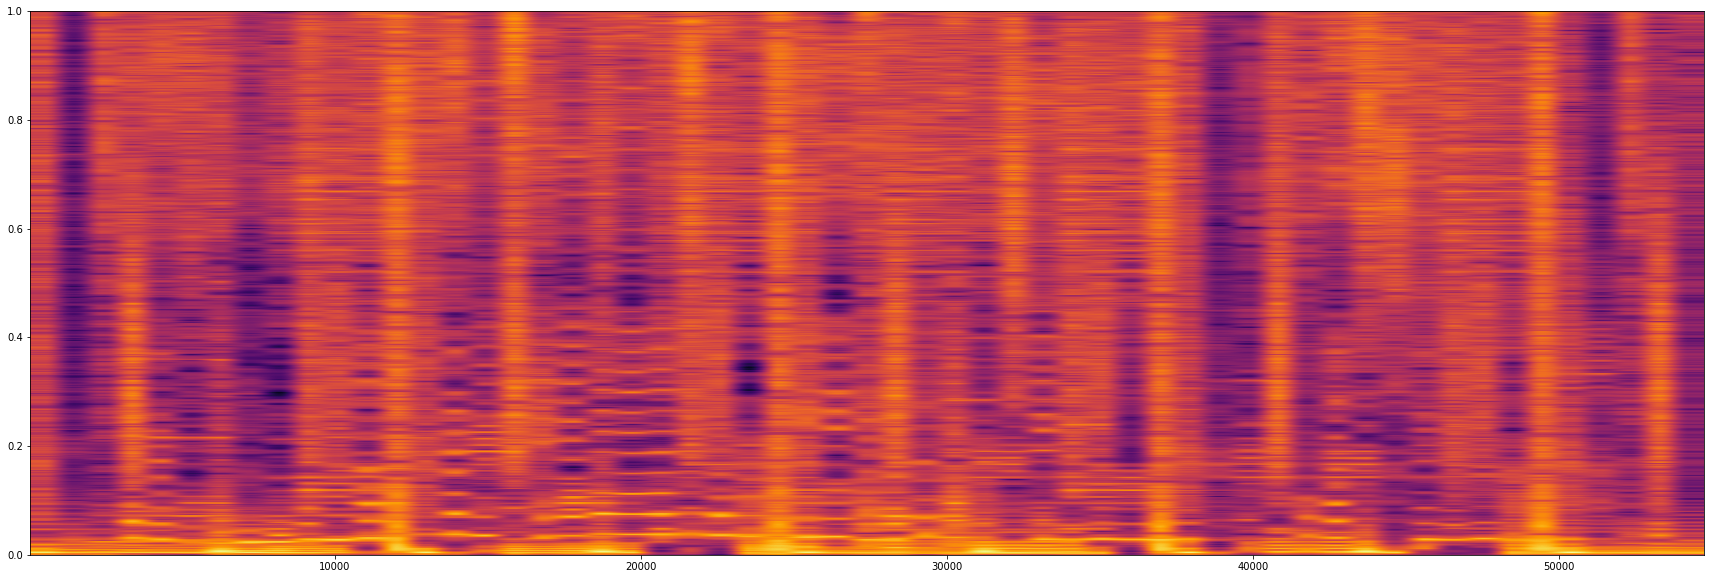

In [ ]:
cmap = plt.get_cmap('inferno')
time.sleep(1)
plt.figure(figsize=(30,10))
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
# plt.xlabel('time ->')#scaled
# plt.ylabel('freq ->')#scaled
# plt.savefig(f'img_data/example2')

Preparing header for input csv

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'

header += ' label'
header = header.split()
header

['filename',
 'chroma_stft',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
pd.DataFrame(pd.read_csv('data.csv')) #Just to display the csv file headers

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label


#Sampling and Feature Extraction: (& storing values in the csv)

In [ ]:
# genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# count =0
# #considering each genre (name of directories)
# for genre in genres:

#   #considering each song in each directory
#   for filename in os.listdir(f'genres/{genre}'):
#     #genre(directory)/audio_file
#     songname = f'genres/{genre}/{filename}'

#     #Sampling of the input:
#     y, sr = librosa.load(songname, mono=True, duration=30)

#     #Parameter Extraction:
#     chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
#     rmse = librosa.feature.rmse(y=y)
#     spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
#     spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#     rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
#     zcr = librosa.feature.zero_crossing_rate(y)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr)

#     #preparing a input row for csv:
#     to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#     for e in mfcc:
#         to_append += f' {np.mean(e)}'
#     to_append += f' {genre}'

#     count +=1
#     print(f'{count} - {to_append}')

#     #writing into csv
#     file = open('data.csv', 'a', newline='')
#     with file:
#         writer = csv.writer(file)
#         writer.writerow(to_append.split())

Reading the saved (input) csv

In [11]:
data=pd.read_csv('data.csv')
print(f'shape = {data.shape}')
data.head()

shape = (1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Transforming genres as numerical value

In [12]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
y.shape, y[:5]

((1000,), array([0, 0, 0, 0, 0]))

In [13]:
data1 = data.drop(['length','filename','label'],axis=1)
data1

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,8860

Creating Scaler for X (input), and storing it for use in predition process

In [14]:
scaler = StandardScaler()

#pickling the scaler object to be used in prediction process
import pickle

with open(r"X_scaler.pickle", "wb") as output_file:
  pickle.dump(scaler, output_file)

#transforming the training X dataset
X = scaler.fit_transform(np.array(data1, dtype = float))
X

array([[-0.35013678,  0.31258717, -0.01068969, ..., -0.30059734,
         0.60406407, -0.51298758],
       [-0.46248155,  1.11757233, -0.53285232, ..., -0.40708699,
         0.42412706, -0.53842129],
       [-0.18422456, -0.13770124,  0.67997762, ..., -0.52729705,
        -0.29618888, -0.8749539 ],
       ...,
       [ 0.65463736, -1.43198917, -0.75062494, ..., -0.63865065,
        -0.26361549, -0.89060474],
       [-0.19833855,  0.66814351, -0.71697762, ..., -0.5114848 ,
        -0.65064889, -0.63768256],
       [-0.2483391 , -0.05894495, -1.1648952 , ...,  0.16033426,
         0.5868411 , -0.4526752 ]])

Train - Test split

In [70]:
#creating a test and train split 80-20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (800, 57), X_test: (200, 57), y_train: (800,), y_test: (200,)


ANN training

In [71]:
from keras import models
from keras import layers

model = models.Sequential([
                           
layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
layers.Dropout(0.5),

layers.Dense(128, activation='relu'),
layers.Dropout(0.5),

layers.Dense(64, activation='relu'),
layers.Dropout(0.5),

layers.Dense(10, activation='softmax')

])


In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:
model.fit(X_train, y_train, epochs=500, batch_size=128)

Epoch 1/500
7/7 [==============================] - 0s 2ms/step - loss: 2.6394 - accuracy: 0.1125
Epoch 2/500
7/7 [==============================] - 0s 2ms/step - loss: 2.3590 - accuracy: 0.1300
Epoch 3/500
7/7 [==============================] - 0s 2ms/step - loss: 2.2294 - accuracy: 0.1663
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 2.1600 - accuracy: 0.1925
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 2.0990 - accuracy: 0.2425
Epoch 6/500
7/7 [==============================] - 0s 2ms/step - loss: 2.0690 - accuracy: 0.2512
Epoch 7/500
7/7 [==============================] - 0s 2ms/step - loss: 1.9764 - accuracy: 0.2587
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 1.9013 - accuracy: 0.3075
Epoch 9/500
7/7 [==============================] - 0s 2ms/step - loss: 1.8833 - accuracy: 0.3212
Epoch 10/500
7/7 [==============================] - 0s 2ms/step - loss: 1.8668 - accuracy: 0.3125
Epoch 11/500
7/7 [===========

In [74]:
test_loss, test_acc = model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.6777 - accuracy: 0.7650


**Hence Final Training accuracy reached 0.98,
and Test accuracy is 0.76**